# <font color=#CC3971><center>**PARTICIPEZ A LA CONCEPTION D'UNE VOITURE AUTONOME**</center></font>
# <font color=#FCF57C><center>**Structure des données et analyse exploratoire**</center></font>

# <font color=salmon>PART 1 - CONTEXTE DU PROJET</font>

![fvt](https://drive.google.com/uc?export=view&id=1jpDlPR2VP5BRNgbnTna666EDun4GPRQ2)

## **<font color=green>L'entreprise</font>**

**Future Vision Transport** est une entreprise qui conçoit des <font color=#FCF57C>systèmes embarqués de vision par ordinateur pour les voitures autonomes</font>. 

Ces **systèmes dédiés aux véhicules autonomes** embarquent plusieurs programmes, combinant la vision - c'est-à-dire, la perception de l'environnement, mais également le calcul des distances.

## **<font color=green>L'équipe</font>**

L'équipe R&D est composée de plusieurs ingénieurs spécialisés dans les 4 composantes de la partie **Vision** du système embarqué :
1. l'acquisition des images en temps réel ;
2. le traitement des images ;
3. la segmentation des images ; 
4. et enfin, le système de décision.

## **<font color=green>La mission</font>**

Notre mission se focalisera sur la partie 3 de système embarqué : **concevoir, entraîner et déployer un modèle de segmentation d'images**, qui s'intégrera facilement dans la chaîne complète.

# <font color=salmon>PART 2 - JEU DE DONNEES</font>

## **<font color=green>Cityscapes Dataset</font>**

Nous allons travailler avec le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) (*cliquer sur le lien*).

## **<font color=green>Données disponibles</font>**
Le dataset a été subdivisé par ses créateurs en 3 jeux :
-	Le **Train Set**, constitué de 2975 images et masques annotés, disponibles publiquement ;
-	Le **Validation Set**, constitué de 500 images et masques annotés, disponibles publiquement ;
-	Le **Test Set**, constitué de 1525 images <font color=orange>dont les annotations ne sont pas divulguées à des fins d’évaluation</font>.

> **Actions** : 
- Travailler uniquement les jeux de **Train** et **Validation** pour pouvoir entraîner et évaluer les modèles (capacité à prédire correctement) ;
- Garder le set **Validation** pour en faire un set de **Test** ;
- Créer un nouveau set de **Validation** en faisant un split sur le set **Train** : 80% pour l'entraînement, 20% pour la validation.

## **<font color=green>Structure des données</font>**

De plus, les images et masques sont contenus dans 2 dossiers :
- <code>**leftlmg8bit**</code>, qui contient les dossiers train, val et test des images d'origines ;
- <code>**gtFine**</code>, qui contient les dossiers train, val et test des images labellisées avec 30 catégories.

Nous corrigeons cette structure particulière, afin d'assurer l'intégrité des différents sets de données, et de faciliter l'appel des images et masques par nos modèles à tester.

> **Actions** : 
- Modifier la structure des données pour avoir d'abord en **dossier principal les sets Train / Val / Test** ;
- Supprimer les dossiers intermédiaires de villes ;
- Renommer les images en supprimant les suffixes <code>_leftlmg8bit</code> et <code>_gtFine_labelIds</code>, pour s'assurer que les images et leurs masques annotés portent exactement le même nom.

## **<font color=green>Annotations des masques</font>**

Les masques annotés viennent avec **30 affectations de classes**. 

Dans notre projet, nous avons uniquement besoin des **8 catégories principales** telles que décrites dans le tableau ci-dessous: 

| 8 catégories principales | 8 IDs | Couleur de segmentation |
| :--: | :--: | :--: |
| void | 0 | Gris clair |
| flat | 1 | Rouge |
| construction | 2 | Jaune |
| object | 3 | Vert clair | 
| nature | 4 | Vert foncé |
| sky | 5 | Bleu clair |
| human | 6 | Bleu roi |
| vehicle | 7 | Noir | 

> **Actions** : 
- Créer une table de correspondance (mapper) les 30 classes vers leur catégorie principale.
- Sauvegarder les images pour une utilisation ultérieure.

# <font color=salmon>PART 3 - REORGANISATION DES DONNEES</font>

## **<font color=green>Import des librairies</font>**

In [1]:
from IPython.display import clear_output
!pip install git+https://github.com/aleju/imgaug.git
clear_output()

In [2]:
# Import libraries
import numpy as np
import random
import os
from glob import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, Counter
from tqdm import tqdm
from imgaug import augmenters as iaa

%matplotlib inline

## **<font color=green>Déplacement des images et masques vers les dossiers finaux</font>**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set origin folders
train_image_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/leftImg8bit/train/*/*.png'
train_mask_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/gtFine/train/*/*_labelIds.png'
val_image_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/leftImg8bit/val/*/*.png'
val_mask_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/gtFine/val/*/*_labelIds.png'

# Set final destination folders
train_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/images'
train_masks30_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/masks30'
test_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/images'
test_masks30_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/masks30'

In [5]:
# Function to move file from origin to destination path
def move_files(origin, destination):
    # Check if origin is directory or list
    if isinstance(origin, list):
        origin_fname = origin
    else :
        origin_fname = glob(origin)
    
    for file in origin_fname:
        shutil.move(file, destination)

In [6]:
move_files(train_image_dir, train_input_dir)
move_files(train_mask_dir, train_masks30_dir)
move_files(val_image_dir, test_input_dir)
move_files(val_mask_dir, test_masks30_dir)

In [7]:
print('Train Images Count: ', len(os.listdir(train_input_dir)), '- 1st file name: ', sorted(os.listdir(train_input_dir))[0])
print('Train Masks Count: ', len(os.listdir(train_masks30_dir)), '- 1st file name: ', sorted(os.listdir(train_masks30_dir))[0])
print('Test Images Count: ', len(os.listdir(test_input_dir)), '- 1st file name: ', sorted(os.listdir(test_input_dir))[0])
print('Test Masks Count: ', len(os.listdir(test_masks30_dir)), '- 1st file name: ', sorted(os.listdir(test_masks30_dir))[0])

Train Images Count:  2975 - 1st file name:  aachen_000000_000019_leftImg8bit.png
Train Masks Count:  2975 - 1st file name:  aachen_000000_000019_gtFine_labelIds.png
Test Images Count:  500 - 1st file name:  frankfurt_000000_000294_leftImg8bit.png
Test Masks Count:  500 - 1st file name:  frankfurt_000000_000294_gtFine_labelIds.png


## **<font color=green>Renommage des images et masques</font>**

In [8]:
# Create a function to rename files
def rename_file(path, is_mask=False):
    """ Provide path of file to be renamed
    """
    # Create a list of file
    file_list = np.array(os.listdir(path))

    # Iterate over the filelist
    for filename in file_list:
        if is_mask == True:
            dest = filename.split('_gtFine_labelIds')[0]+'.png'
        else:
            dest = filename.split('_leftImg8bit')[0]+'.png'

        src = path + '/' + filename
        dest = path + '/' + dest
        os.rename(src, dest)

In [9]:
# # Call the function
rename_file(train_input_dir, is_mask=False)
rename_file(train_masks30_dir, is_mask=True)
rename_file(test_input_dir, is_mask=False)
rename_file(test_masks30_dir, is_mask=True)

In [10]:
print('Train Images Count: ', len(os.listdir(train_input_dir)), '- 1st file name: ', sorted(os.listdir(train_input_dir))[0])
print('Train Masks Count: ', len(os.listdir(train_masks30_dir)), '- 1st file name: ', sorted(os.listdir(train_masks30_dir))[0])
print('Test Images Count: ', len(os.listdir(test_input_dir)), '- 1st file name: ', sorted(os.listdir(test_input_dir))[0])
print('Test Masks Count: ', len(os.listdir(test_masks30_dir)), '- 1st file name: ', sorted(os.listdir(test_masks30_dir))[0])

Train Images Count:  2975 - 1st file name:  aachen_000000_000019.png
Train Masks Count:  2975 - 1st file name:  aachen_000000_000019.png
Test Images Count:  500 - 1st file name:  frankfurt_000000_000294.png
Test Masks Count:  500 - 1st file name:  frankfurt_000000_000294.png


## **<font color=green>Création du set Validation</font>**

In [11]:
# Set validation folder
val_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/images'
val_masks30_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/masks30'

In [12]:
# Sort the images and masks of Train dataset
train_input_fname = sorted(
    [os.path.join(
        train_input_dir, fname) for fname in os.listdir(train_input_dir)])

train_target_fname = sorted(
    [os.path.join(
        train_masks30_dir, fname) for fname in os.listdir(train_masks30_dir)])

In [13]:
# Split into train and validation data
val_input_path = train_input_fname[2380:]
val_target_path = train_target_fname[2380:]

In [14]:
# # Move files from Train to Val
move_files(val_input_path, val_input_dir)
move_files(val_target_path, val_masks30_dir)

In [15]:
# Check files
print('Val Images Count: ', len(os.listdir(val_input_dir)), '- 1st file name: ', sorted(os.listdir(val_input_dir))[0])
print('Val Masks Count: ', len(os.listdir(val_masks30_dir)), '- 1st file name: ', sorted(os.listdir(val_masks30_dir))[0])

Val Images Count:  595 - 1st file name:  stuttgart_000104_000019.png
Val Masks Count:  595 - 1st file name:  stuttgart_000104_000019.png


# <font color=salmon>PART 4 - MAPPING VERS LES 8 CATEGORIES PRINCIPALES</font>

## **<font color=green>Méthodologie de mapping</font>**

Nous allons utilisé la méthodologie d'un des créateurs du jeu de données : [Github de Marius Cordts](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py).

In [16]:
# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

In [17]:
# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    
    # Get the mapping
    map_category = np.vectorize(cat_label.get)
    return map_category

## **<font color=green>Sauvegarde des masks corrigés</font>**

Nous allons sauvegardés les masques corrigés des annotations avec les 8 catégories principales pour accélérer notre benchmark des modèles.

In [18]:
# Set masks folders with 8 main categories
train_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/masks'
val_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/masks'
test_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/masks'

In [19]:
# Function to create new masks 
def old_to_new_mask(img_path, msk30_path, msk8_path, labels):
    # Create lists
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)

    # Sort list
    img_list.sort()
    msk30_list.sort()

    for i in range(0, len(img_list)):
        # Read images and masks
        img = cv2.imread(f'{img_path}/{img_list[i]}')/255
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        
        # Convert msk30 to msk8
        map_category = map_id2category(labels)
        msk8 = map_category(msk30)

        # Save new masks on disk
        cv2.imwrite(f'{msk8_path}/{msk30_list[i]}', msk8)

In [20]:
# Save the masks for TRAIN
old_to_new_mask(train_input_dir, train_masks30_dir, train_target_dir, labels)

# Save the masks for VAL
old_to_new_mask(val_input_dir, val_masks30_dir, val_target_dir, labels)

# Save the masks for TEST
old_to_new_mask(test_input_dir, test_masks30_dir, test_target_dir, labels)

In [21]:
print('Train Images Count: ', len(os.listdir(train_input_dir)), '- 1st file name: ', sorted(os.listdir(train_input_dir))[0])
print('Train Masks Count: ', len(os.listdir(train_target_dir)), '- 1st file name: ', sorted(os.listdir(train_target_dir))[0])
print('Val Images Count: ', len(os.listdir(val_input_dir)), '- 1st file name: ', sorted(os.listdir(val_input_dir))[0])
print('Val Masks Count: ', len(os.listdir(val_target_dir)), '- 1st file name: ', sorted(os.listdir(val_target_dir))[0])
print('Test Images Count: ', len(os.listdir(test_input_dir)), '- 1st file name: ', sorted(os.listdir(test_input_dir))[0])
print('Test Masks Count: ', len(os.listdir(test_target_dir)), '- 1st file name: ', sorted(os.listdir(test_target_dir))[0])

Train Images Count:  2380 - 1st file name:  aachen_000000_000019.png
Train Masks Count:  2380 - 1st file name:  aachen_000000_000019.png
Val Images Count:  595 - 1st file name:  stuttgart_000104_000019.png
Val Masks Count:  595 - 1st file name:  stuttgart_000104_000019.png
Test Images Count:  500 - 1st file name:  frankfurt_000000_000294.png
Test Masks Count:  500 - 1st file name:  frankfurt_000000_000294.png


# <font color=salmon>PART 5 - ANALYSE EXPLORATOIRE DES DONNEES</font>

## **<font color=green>Visualisation des images et masques (initiaux et corrigés)</font>**

In [22]:
# Visualise original images, masks30 and masks8
def visualize_img_msk30_msk8(img_path, msk30_path, msk8_path, n=0):
    # Create lists
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)
    msk8_list = os.listdir(msk8_path)

    # Sort list
    img_list.sort()
    msk30_list.sort()
    msk8_list.sort()

    for i in range(n, n+2):
        img = cv2.imread(f'{img_path}/{img_list[i]}')
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        msk8 = cv2.imread(f'{msk8_path}/{msk8_list[i]}',
                          cv2.IMREAD_GRAYSCALE)
        
        # Plot
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 20))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax1.axis('off')
        ax2.imshow(msk30, cmap='nipy_spectral')
        ax2.set_title('True Mask 30')
        ax2.axis('off')
        ax3.imshow(msk8, cmap='nipy_spectral_r')
        ax3.set_title('True Mask 8')
        ax3.axis('off')
        plt.show()

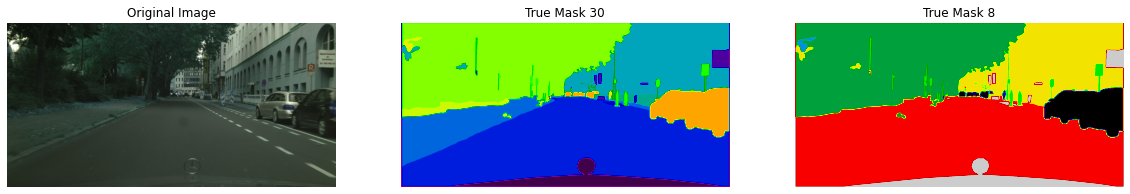

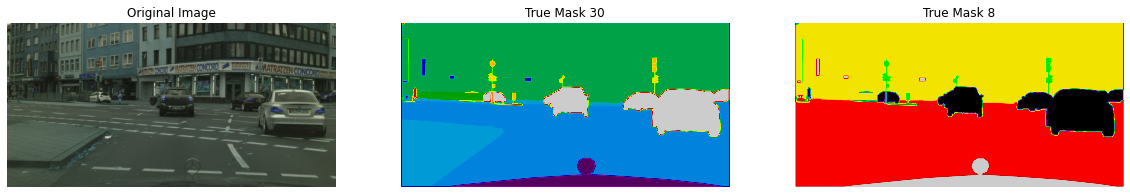

In [23]:
# Call the function
visualize_img_msk30_msk8(train_input_dir, train_masks30_dir, train_target_dir, n=2)

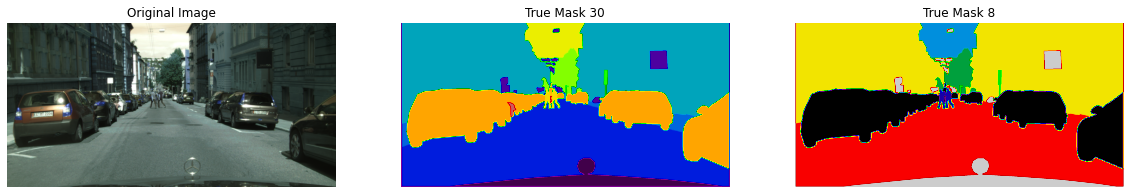

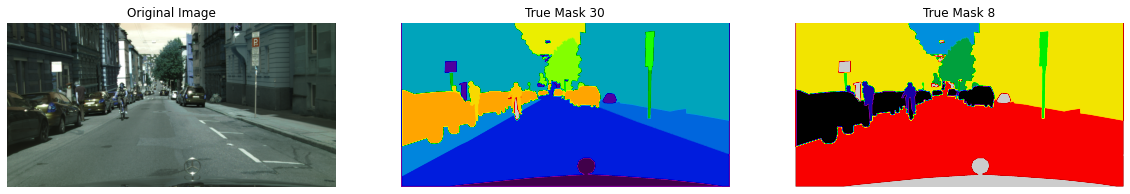

In [24]:
visualize_img_msk30_msk8(val_input_dir, val_masks30_dir, val_target_dir, n=2)

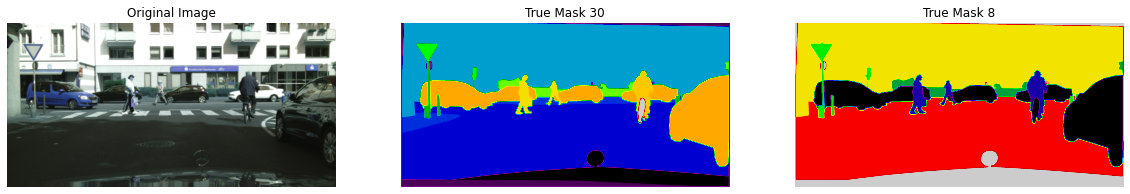

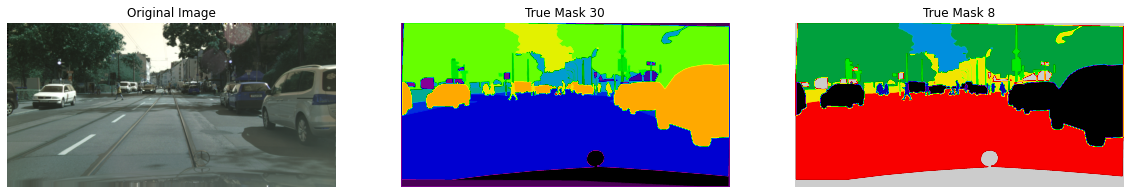

In [25]:
visualize_img_msk30_msk8(test_input_dir, test_masks30_dir, test_target_dir, n=2)

## **<font color=green>Analyse de distribution des classes</font>**

In [26]:
# Function to compute and plot classes' distribution
def class_distribution(msk_path, dataset='Train'):
    msk_list = os.listdir(msk_path)
    msk_list.sort()

    # Create an empty list
    sums = []

    # Load image data
    for i in tqdm(range(0, len(msk_list))):
        mask = cv2.imread(f'{msk_path}/{msk_list[i]}',
                          cv2.IMREAD_GRAYSCALE)
        
        # Return a list of occurence of each unique label value
        (unique, counts) = np.unique(mask, return_counts=True)

        # Store the result in a list of dictionary
        sums.append(dict(zip(unique, counts)))

    # Instantiate a counter
    result_counter = Counter()

    # Iterate over elements in sums
    for elem in sums:
        for key, value in elem.items():
            result_counter[key] += value
    
    # print(result_counter)

    categ = {'void': 0, 'flat': 1, 'construction': 2, 
             'object': 3, 'nature': 4, 'sky': 5, 
             'human': 6, 'vehicle': 7}
    my_colors = ['lightgrey', 'red', 'yellow', 'greenyellow',
                 'forestgreen', 'deepskyblue', 'royalblue', 'black']
    
    # Plot the classes distribution
    plt.figure()
    plt.bar(x=categ.keys(), height=result_counter.values(),
            tick_label=list(categ.keys()), color=my_colors)
    plt.xticks(rotation=45)
    plt.title(dataset +' Classes distribution')
    plt.show()

100%|██████████| 2380/2380 [02:13<00:00, 17.84it/s]


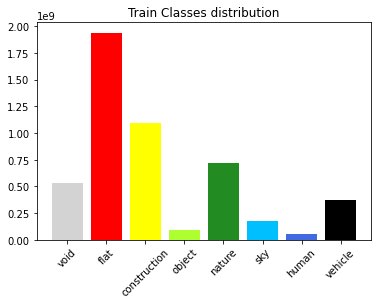

100%|██████████| 595/595 [00:32<00:00, 18.18it/s]


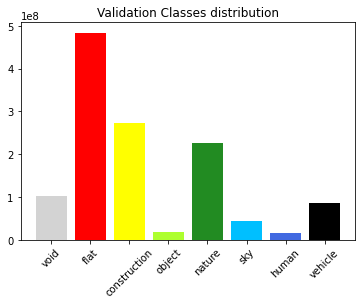

100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


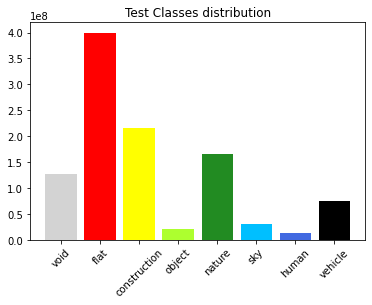

In [27]:
# Call the function
class_distribution(train_target_dir, dataset='Train')
class_distribution(val_target_dir, dataset='Validation')
class_distribution(test_target_dir, dataset='Test')

Nous sommes face à un dataset où les **classes sont déséquilibrées**, ce qui est une situation relativement fréquente sur les datasets. 

Cette information est importante lorsqu'il s'agit de **mesurer la performance de nos modèles**. En effet, il faudra se méfier de l'**exactitude** (ou ***accuracy***) car le modèle prédira probablement les classes sur-représentées avec beaucoup plus de robustesse que les classes sous-représentées.

Il faudra ainsi s'attacher à choisir une métrique adaptée.

# <font color=salmon>PART 5 - AUGMENTATION DES DONNEES</font>

L'augmentation de données est appliquée uniquement aux images et non pas aux masques!

## **<font color=green>Chargement d'une image</font>**

In [28]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

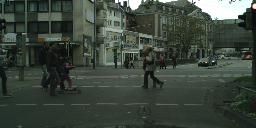

In [29]:
# Set parameters
img_height, img_width = 128, 256
img_size = (img_height, img_width)

# Set path
train_input_path = sorted(glob(train_input_dir + '/*.png'))

# Load image for test
img = load_img(f'{train_input_path[14]}', target_size=img_size)
img

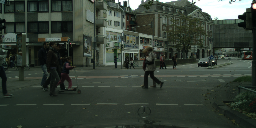

In [30]:
# Test of blur
blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 3.0))])
img_blur = blur_transform(image=img_to_array(img))
array_to_img(img_blur)

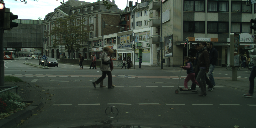

In [31]:
# Test of flip
flip_transform = iaa.Sequential([iaa.Fliplr()])
img_flip = flip_transform(image=img_to_array(img))
array_to_img(img_flip)

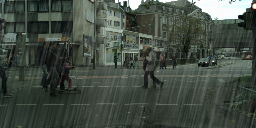

In [32]:
# Test of rain
rain_transform = iaa.Sequential([iaa.Rain(speed=(0.1, 0.3))])
img_rain = rain_transform(image=img_to_array(img))
array_to_img(img_rain)

In [33]:
img_rain.shape

(128, 256, 3)

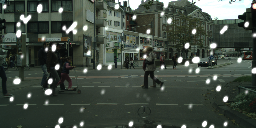

In [34]:
# Test of snowflakes
snowf_transform = iaa.Sequential([iaa.Snowflakes(flake_size=(0.7, 0.8), speed=(0.01, 0.03))])
img_snowf = snowf_transform(image=img_to_array(img))
array_to_img(img_snowf)